# Assignment 2: Stochastic & Spatial SIR Models

Lisa Pahladsingh & Sanjhana Bhusal

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

### 1.1 Implement Gillespies algorithm

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.integrate import odeint

random.seed(0) # ensures same randomness

The sum of the rates (at a time t) define the proportions of the rates in a specific population dynamic of the system. Therefore, if the proportion of infected is very high the recovery rate will make up a higher part of the sum of the rates. Thus, the I->R event is much more likely to happen.

In [14]:
#Defining all necessary functions

# SIR with gillespies algo
def SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu):
    S = [S_0]
    I = [I_0]
    R = [R_0]
    t = [t_0]

# Create a while loop
    while t[-1] < t_end and (S[-1] + I[-1] >= 1):
        
        N = S[-1] + I[-1] + R[-1]
        rates = [mu * N, beta * I[-1] * S[-1]/N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]
        rates_sum = sum(rates)

        if rates_sum != 0:
            tau = np.random.exponential(scale = 1/rates_sum) 

        else:
            tau = 0  

        rand_num = random.uniform(0, 1)

        # Birth
        if rand_num * rates_sum <= rates[0]:
            S.append(S[-1] + 1)
            I.append(I[-1])
            R.append(R[-1])

        # S -> I
        elif rand_num * rates_sum > rates[0] and rand_num * rates_sum <= sum(rates[:2]):
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])

        # I -> R
        elif rand_num * rates_sum > sum(rates[:2]) and rand_num * rates_sum <= sum(rates[:3]):
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)

        # S -> death
        elif rand_num * rates_sum > sum(rates[:3]) and rand_num * rates_sum <= sum(rates[:4]): 
            S.append(S[-1] - 1)
            I.append(I[-1])
            R.append(R[-1])

        # I -> death
        elif rand_num * rates_sum > sum(rates[:4]) and rand_num * rates_sum <= sum(rates[:5]): 
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])

        # R -> death
        elif rand_num * rates_sum > sum(rates[:5]) and rand_num * rates_sum <= sum(rates[:6]): 
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1] - 1)

        t.append(t[-1] + tau)
    
    return(t, S, I, R)

# Define SIR model with demography
def SIR_dem(y, t, beta, gamma, mu):
    S = y[0]
    I = y[1]
    R = y[2]
    
    dSdt = mu - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    
    return [dSdt, dIdt, dRdt]

### Plotting Gillespies for a single run

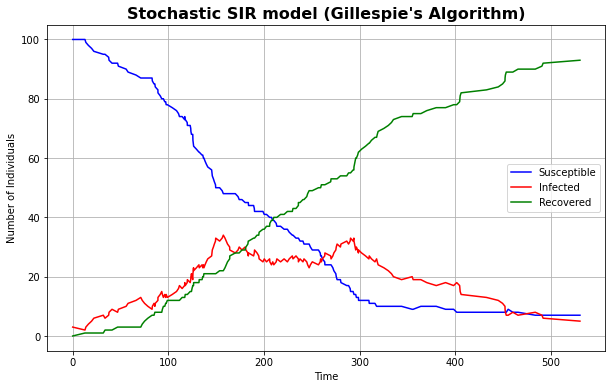

In [15]:
# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptible', color='blue')
plt.plot(t, I, label='Infected', color='red')
plt.plot(t, R, label='Recovered', color='green')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title("Stochastic SIR model (Gillespie's Algorithm)", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### Gillespies averaged over a number of runs

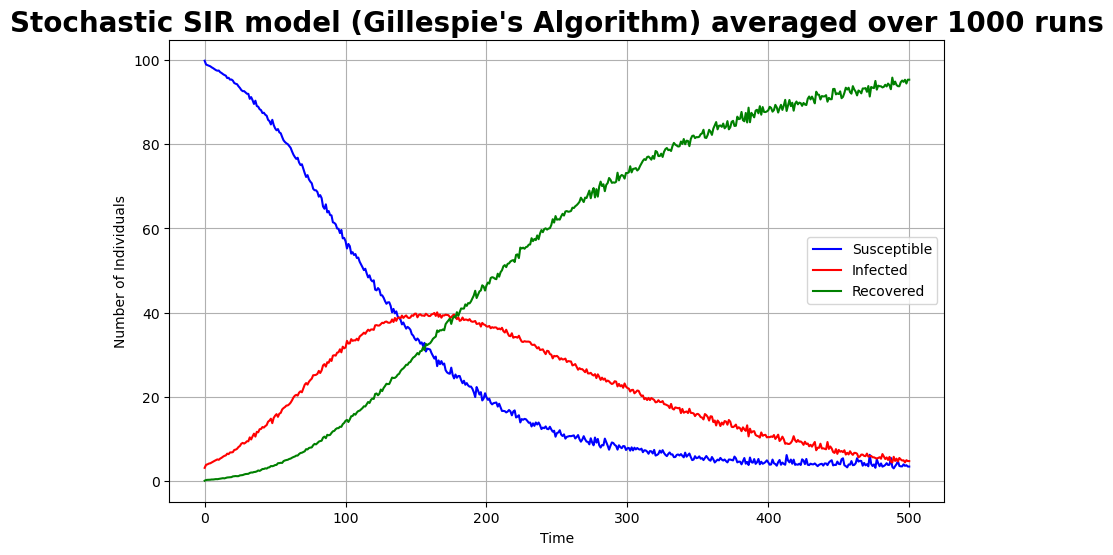

In [20]:
# Setting up function for averaging
def GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim):

    # Setting data range
    t_data = np.linspace(0, t_end, t_end+1)
    S_data = np.empty((t_end+1, 0)).tolist()
    I_data = np.empty((t_end+1, 0)).tolist() 
    R_data = np.empty((t_end+1, 0)).tolist()

    for _ in range(n_sim):
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
        for i, time in enumerate(t):
            # Add S, I, R values from GA to predefined list
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

    # Average values
    for i in range(len(t_data)):
        if len(S_data[i]) == 0:
            S_data[i] = S_data[i-1]
            I_data[i] = I_data[i-1]
            R_data[i] = R_data[i-1]
        else:
            S_data[i] = sum(S_data[i])/len(S_data[i])
            I_data[i] = sum(I_data[i])/len(I_data[i])
            R_data[i] = sum(R_data[i])/len(R_data[i])
            
    return t_data, S_data, I_data, R_data

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_sim = 1000

t_data, S_data, I_data, R_data = GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t_data, S_data, label='Susceptible', color='blue')
plt.plot(t_data, I_data, label='Infected', color='red')
plt.plot(t_data, R_data, label='Recovered', color='green')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title(f"Stochastic SIR model (Gillespie's Algorithm) averaged over {n_sim} runs", fontsize=20, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### 1.2: Comparing variance anc covariance between runs

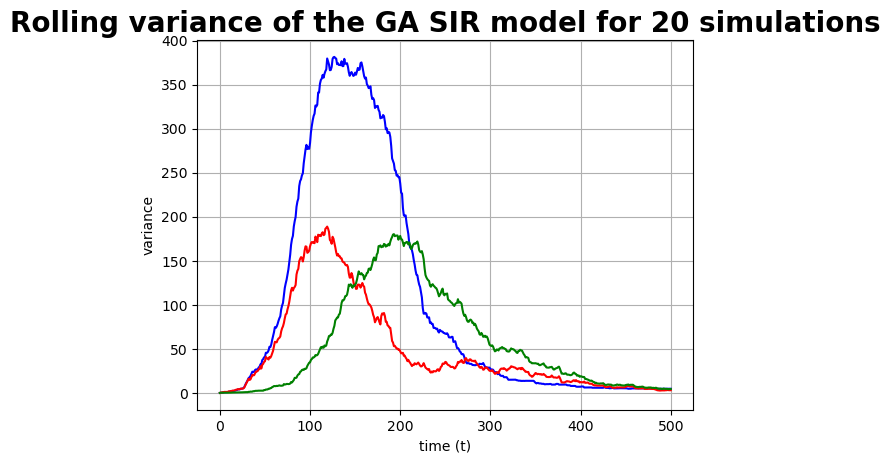

In [23]:
# Setting up function for variance
def GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run):

    # Setting range for binning of values
    t_data = np.linspace(0, t_end, t_end+1)
    
    # Setting data range
    S_df = pd.DataFrame(index=t_data)
    I_df = pd.DataFrame(index=t_data) 
    R_df = pd.DataFrame(index=t_data)
    
    for i_run in range(n_run):
        
        # Setting empty list of bins
        S_data = np.empty((t_end+1, 0)).tolist()
        I_data = np.empty((t_end+1, 0)).tolist() 
        R_data = np.empty((t_end+1, 0)).tolist()
        
        # Getting data
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

        for i, time in enumerate(t):
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

        for i in range(len(t_data)):
            if len(S_data[i]) == 0:
                S_data[i] = S_data[i-1]
                I_data[i] = I_data[i-1]
                R_data[i] = R_data[i-1]
            else:
                S_data[i] = sum(S_data[i])/len(S_data[i])
                I_data[i] = sum(I_data[i])/len(I_data[i])
                R_data[i] = sum(R_data[i])/len(R_data[i])
        
        # Adding to df
        S_df[str(i_run)] = S_data
        I_df[str(i_run)] = I_data
        R_df[str(i_run)] = R_data
      
    
    S_df_var = S_df.var(axis=1, ddof=0)
    I_df_var = I_df.var(axis=1, ddof=0)
    R_df_var = R_df.var(axis=1, ddof=0)
        
    return S_df_var, I_df_var, R_df_var

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_run = 20

S_var, I_var, R_var = GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run)
S_var.plot(label="var Susceptibles", color='blue')
I_var.plot(label="var Infected", color='red')
R_var.plot(label="var Recovered", color='green')
plt.xlabel("time (t)")
plt.ylabel("variance")
plt.title(f"Rolling variance of the GA SIR model for {n_test} simulations", fontsize=20, fontweight='bold')
plt.grid(True)
plt.show()

## Problem 2: Spatial Models - Networks

In [1]:
pip install ndlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
#import libraries
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend as BokehDiffusionTrend
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import ndlib.models.epidemics as ep


### 2.1 Exploring the implementation of SIR on one network

In [10]:
#Defining the random network 
number_nodes = 1000
prob_link = 0.1
graph = nx.erdos_renyi_graph(number_nodes, prob_link)

# selecting SIR model
SIRmodel = ep.SIRModel(graph)

In [11]:
# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
SIRmodel.set_initial_status(config)

In [12]:
# multiple Simulation
iterations = SIRmodel.iteration_bunch(200)
trends = SIRmodel.build_trends(iterations)

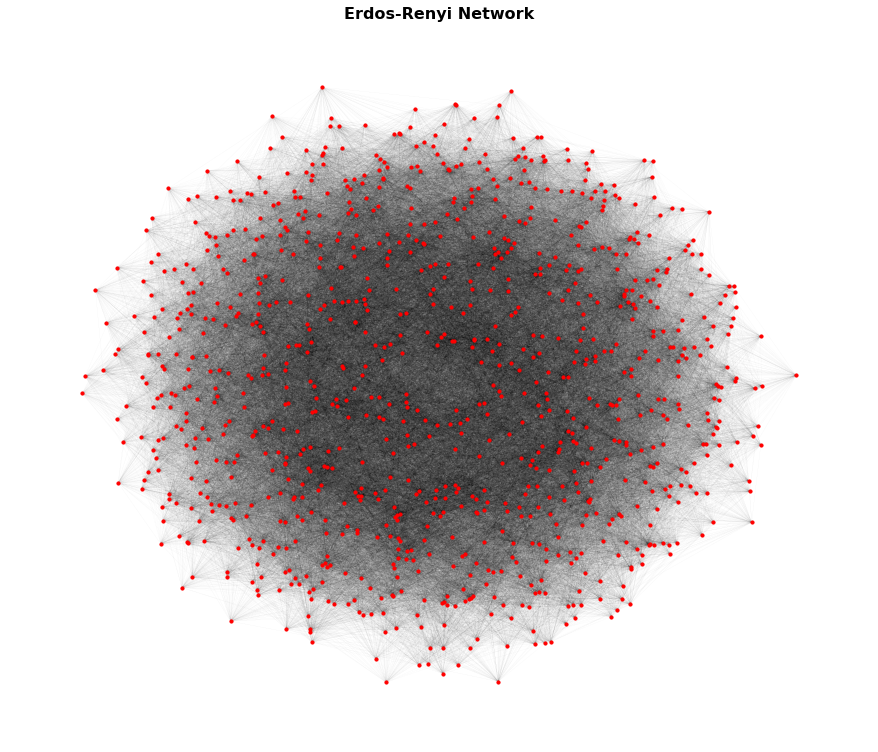

In [13]:
#visualizing the network itself
plt.figure(figsize=(12, 10))
positioning = nx.spring_layout(graph)  # Position of the nodes

edge_colour = 'black' 
edge_width = 0.01

nx.draw(graph, positioning, node_size=10, node_color='r', with_labels=False, edge_color=edge_colour, width=edge_width)
plt.title("Erdos-Renyi Network", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

In [14]:
viz = DiffusionTrend(SIRmodel, trends)
p = viz.plot(width=400, height=400)
output_notebook()
show(p)

Loading BokehJS ...

In [15]:
#prevalence plot: variation of nodes across iterations
viz2 = DiffusionPrevalence(SIRmodel, trends)
p2 = viz2.plot(width=400, height=400)
output_notebook()
show(p2)

Loading BokehJS ...

In [16]:
vm = MultiPlot()
vm.add_plot(p)

# SIS
sis_model = ep.SISModel(graph)
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('lambda', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
sis_model.set_initial_status(config)
iterations = sis_model.iteration_bunch(200)
trends = sis_model.build_trends(iterations)

#creating a bokeh plot for SIS
viz = DiffusionTrend(sis_model, trends)
p3 = viz.plot(width=400, height=400)
vm_sis = MultiPlot()
vm_sis.add_plot(p3)

# SI
si_model = ep.SIModel(graph)
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter("fraction_infected", 0.05)
si_model.set_initial_status(config)
iterations = si_model.iteration_bunch(200)
trends = si_model.build_trends(iterations)

#bakeh plot for SI
viz_si = BokehDiffusionTrend(si_model, trends)
p4 = viz_si.plot(width=400, height=400)
vm_si = MultiPlot()
vm_si.add_plot(p4)

# Threshold
th_model = ep.ThresholdModel(graph)
config = mc.Configuration()

# Set individual node threshold
threshold = 0.40
for n in graph.nodes():
        config.add_node_configuration("threshold", n, threshold)

config.add_model_parameter("fraction_infected", 0.30)
th_model.set_initial_status(config)
iterations = th_model.iteration_bunch(60)
trends = th_model.build_trends(iterations)

#Bokeh plot for threshold 
viz = DiffusionTrend(th_model, trends)
p5 = viz.plot(width=400, height=400)
vm_threshold = MultiPlot()
vm_threshold.add_plot(p5)

# Plot all bokeh visualisations
m_sis = vm_sis.plot()
m_si = vm_si.plot()
m_threshold = vm_threshold.plot()

output_notebook()

# Show the plots
show(m_sis)
show(m_si)
show(m_threshold)

Loading BokehJS ...

### 2.2 Generating multiple models and analysis of the statistics


In [18]:
pip install altair==4.1.0

Note: you may need to restart the kernel to use updated packages.


#### 2.2.1 Generating  the networks and simulating SIR


In [17]:

# initializing parameters networks
number_nodes = 1000
prob_link = 0.1
k = 4

random_graph = nx.erdos_renyi_graph(number_nodes, prob_link)
barabasi_albert_graph = nx.scale_free_graph(number_nodes)
watts_strogatz_graph = nx.watts_strogatz_graph(number_nodes, k, 0.1)


In [18]:
def create_networks(network_type):
    if network_type == "random":
        return nx.erdos_renyi_graph(number_nodes, prob_link)
    elif network_type == "barabasi_albert":
        return nx.barabasi_albert_graph(number_nodes, 2)
    elif network_type == "watts_strogatz":
        return nx.watts_strogatz_graph(number_nodes, k, 0.1)
    else:
        raise ValueError("Invalid graph type")

#running the SIR on different networks
def run_SIR(network_type):
    # selecting SIR model
    SIRmodel = ep.SIRModel(create_networks(network_type))
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.04)
    config.add_model_parameter('gamma', 0.01)
    config.add_model_parameter("fraction_infected", 0.05)
    SIRmodel.set_initial_status(config)
    
    # multiple Simulation
    iterations = SIRmodel.iteration_bunch(200)
    trends = SIRmodel.build_trends(iterations)
    return trends

# Run simulations for each graph type
random_graph_trends = run_SIR("random")
barabasi_albert_graph_trends = run_SIR("barabasi_albert")
watts_strogatz_graph_trends = run_SIR("watts_strogatz")

In [23]:
from bokeh.plotting import show, output_notebook
from bokeh.models import Title, Label

#Visualizing the data
#Random network
viz = DiffusionTrend(SIRmodel, random_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Random Network"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)

#barabasi_albert network
viz = DiffusionTrend(SIRmodel, barabasi_albert_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Barabasi-Albert"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)

#watts_strogatz network 
viz = DiffusionTrend(SIRmodel, watts_strogatz_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Watts-Strogatz"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

#### 2.2.2 Analysing the statistics of the networks

In [27]:
#repeat: the networks with SIR simulations
random_graph
barabasi_albert_graph
watts_strogatz_graph   

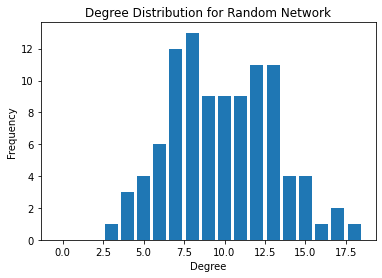

Centrality Measures for Random Network:
Node 0:
  Degree Centrality: 0.06060606060606061
  Betweenness Centrality: 0.0023018359763344832
  Closeness Centrality: 0.4230769230769231
  Eigenvector Centrality: 0.06852605895907395

Node 1:
  Degree Centrality: 0.14141414141414144
  Betweenness Centrality: 0.019845426028614933
  Closeness Centrality: 0.49748743718592964
  Eigenvector Centrality: 0.16434670362790946

Node 2:
  Degree Centrality: 0.08080808080808081
  Betweenness Centrality: 0.005851126215846268
  Closeness Centrality: 0.4267241379310345
  Eigenvector Centrality: 0.07617692170393044

Node 3:
  Degree Centrality: 0.08080808080808081
  Betweenness Centrality: 0.007172843244438885
  Closeness Centrality: 0.42857142857142855
  Eigenvector Centrality: 0.0794681085451423

Node 4:
  Degree Centrality: 0.05050505050505051
  Betweenness Centrality: 0.004626156834058033
  Closeness Centrality: 0.39919354838709675
  Eigenvector Centrality: 0.0408844684695794

Node 5:
  Degree Centrality:

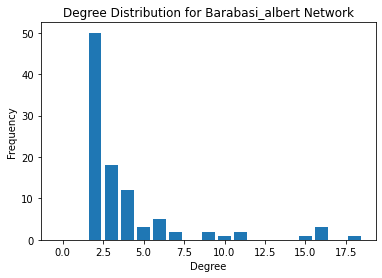

Centrality Measures for Barabasi_albert Network:
Node 0:
  Degree Centrality: 0.16161616161616163
  Betweenness Centrality: 0.18571582734884406
  Closeness Centrality: 0.4604651162790698
  Eigenvector Centrality: 0.3152781818741395

Node 1:
  Degree Centrality: 0.16161616161616163
  Betweenness Centrality: 0.19689095475591895
  Closeness Centrality: 0.4782608695652174
  Eigenvector Centrality: 0.36393578996868065

Node 2:
  Degree Centrality: 0.020202020202020204
  Betweenness Centrality: 0.007263598079924611
  Closeness Centrality: 0.32038834951456313
  Eigenvector Centrality: 0.04870528253978417

Node 3:
  Degree Centrality: 0.16161616161616163
  Betweenness Centrality: 0.17326398549342278
  Closeness Centrality: 0.4439461883408072
  Eigenvector Centrality: 0.25314124970561597

Node 4:
  Degree Centrality: 0.18181818181818182
  Betweenness Centrality: 0.21273329683239098
  Closeness Centrality: 0.4782608695652174
  Eigenvector Centrality: 0.38871217884844594

Node 5:
  Degree Central

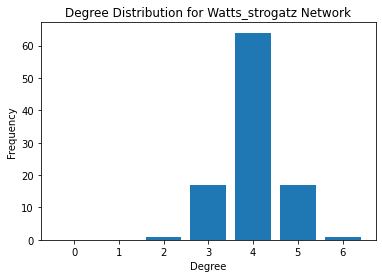

Centrality Measures for Watts_strogatz Network:


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [28]:
# a lit of the three networks
network_types = ["random", "barabasi_albert", "watts_strogatz"]

for network_type in network_types:
    if network_type == "random":
        G = nx.erdos_renyi_graph(100, 0.1)
    elif network_type == "barabasi_albert":
        G = nx.barabasi_albert_graph(100, 2)
    elif network_type == "watts_strogatz":
        G = nx.watts_strogatz_graph(100, 4, 0.1) 

    # Degree distribution
    degree_sequence = [d for n, d in G.degree()]
    degree_count = nx.degree_histogram(G)
    degrees = range(len(degree_count))

    plt.bar(degrees, degree_count)
    plt.title(f"Degree Distribution for {network_type.capitalize()} Network")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate and print various centrality measures
    print(f"Centrality Measures for {network_type.capitalize()} Network:")
    
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    
    for node in G.nodes():
        print(f"Node {node}:")
        print(f"  Degree Centrality: {degree_centrality[node]}")
        print(f"  Betweenness Centrality: {betweenness_centrality[node]}")
        print(f"  Closeness Centrality: {closeness_centrality[node]}")
        print(f"  Eigenvector Centrality: {eigenvector_centrality[node]}")
        print()